# Index
1. Reconstruction LSTM AutoEncoder
2. Prediction LSTM AutoEncoder
3. Composite LSTM AutoEncoder
4. Standalone LSTM AutoEncoer 

 
# 1. Reconstruction LSTM AutoEncoder
- 가장 간단한 LSTM 오토인코더는 각 인풋 Sequence를 학습해서 reconstruct함 
- 9개의 간단한 수열로 연습 

## tip)
- Pretrained 형태로 활용이 *가능함*

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

datadir = '/gdrive/My Drive/colab/TimeSeries/dataset'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model
from keras.layers import Input
from keras.models import Model

Using TensorFlow backend.


In [3]:
# define input sequence
sequence = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
# reshape input into [samples, timesteps, features]
n_in = len(sequence)
print(sequence.shape)
sequence = sequence.reshape((1, n_in, 1)) # 3-tensor의 구조로 변경
print(sequence.shape)

(9,)
(1, 9, 1)


인코더-디코더 LSTM 구조를 정의해야함. 
9개의 타임스텝을 인풋시퀀스로 받고 (피쳐는1개) 아웃풋으로 9개의 타임스텝으로 냄 (피쳐는1개) 

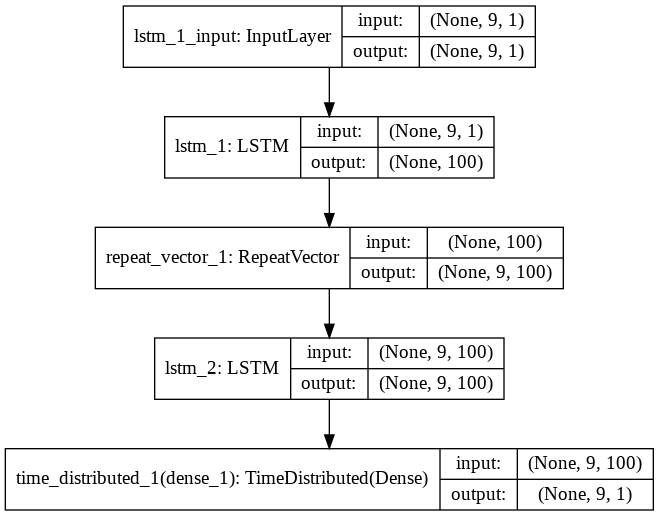

In [4]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_in,1)))   # (1, 9, 1)에서 1번 축은 무시하고 2, 3번의 축만을 사용해서 input의 값을 넣어줌(9, 1) 
model.add(RepeatVector(n_in))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(sequence, sequence, epochs=300, verbose=0)
plot_model(model, show_shapes=True, to_file='reconstruct_lstm_autoencoder.png')

In [5]:
# demonstrate recreation
yhat = model.predict(sequence, verbose=0)
print(yhat[0,:,0])

[0.11239918 0.20713462 0.30273405 0.3991938  0.49668282 0.59551245
 0.69612026 0.7990634  0.90502286]


# 2. LSTM AutoEncoder
- ***Prediction LSTM AutoEncoder***
- 위의 모델을 수정해서 재생성이 아닌 예측모델을 만듬 
- 아웃풋은 [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] 와 근점해야함 
- 모델은 인풋 시퀀스가 9개이고 아웃풋 시퀀스는 8개 



In [0]:
# define input sequence
seq_in = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
# reshape input into [samples, timesteps, features]
n_in = len(seq_in)
seq_in = seq_in.reshape((1, n_in, 1))
# prepare output sequence
seq_out = seq_in[:, 1:, :]
n_out = n_in - 1

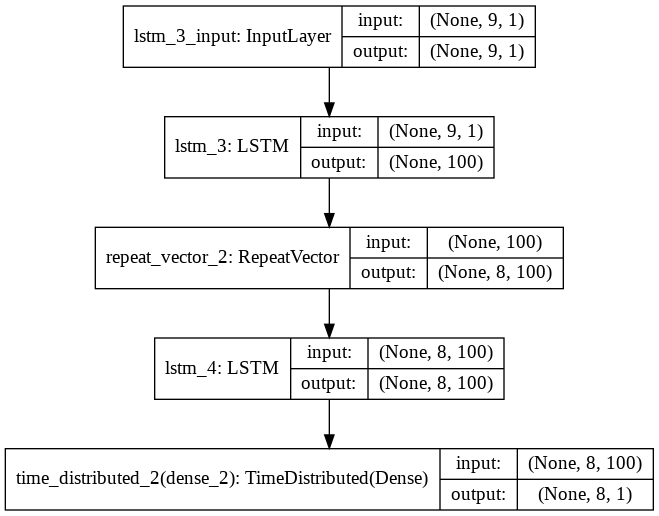

In [7]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_in,1)))
model.add(RepeatVector(n_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
plot_model(model, show_shapes=True, to_file='predict_lstm_autoencoder.png')

In [8]:
# fit model
model.fit(seq_in, seq_out, epochs=300, verbose=0)
# demonstrate prediction
yhat = model.predict(seq_in, verbose=0)
print(yhat[0,:,0])

[0.16503876 0.28827924 0.4024709  0.5094182  0.6105714  0.7071205
 0.80006284 0.8902529 ]


# 3. Composite LSTM AutoEncoder
- ***Composite LSTM AutoEncoder***
- Composite모형에서는 1개의 인코더와 2개의 디코로 이루어져 있고 각각 Reconstruction그리고 예측에 쓰임 


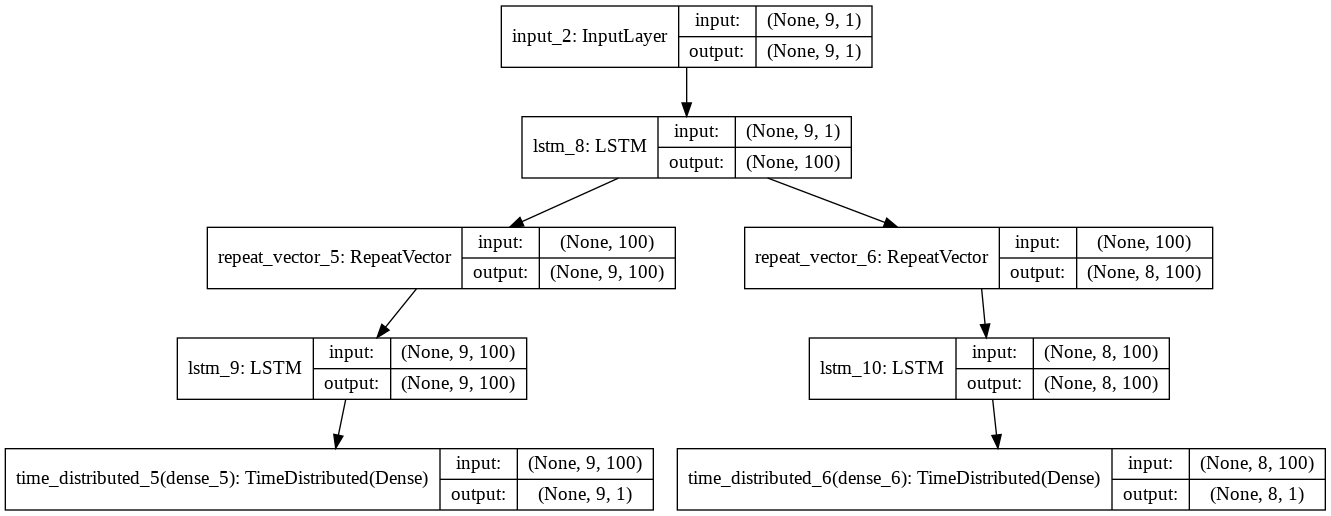

In [12]:
# 인코더정의
visible = Input(shape=(n_in,1))
encoder = LSTM(100, activation='relu')(visible)

#재생성 디코더 정의 
decoder1 = RepeatVector(n_in)(encoder)
decoder1 = LSTM(100, activation='relu', return_sequences=True)(decoder1)
decoder1 = TimeDistributed(Dense(1))(decoder1)

# 예측 디코더 정의
decoder2 = RepeatVector(n_out)(encoder)
decoder2 = LSTM(100, activation='relu', return_sequences=True)(decoder2)
decoder2 = TimeDistributed(Dense(1))(decoder2)

# 최종 모델 정의
model = Model(inputs=visible, outputs=[decoder1, decoder2])
model.compile(optimizer='adam', loss='mse')
plot_model(model, show_shapes=True, to_file='composite_lstm_autoencoder.png')

In [13]:
# fit model
model.fit(seq_in, [seq_in,seq_out], epochs=300, verbose=0)
# demonstrate prediction
yhat = model.predict(seq_in, verbose=0)
print(yhat)

[array([[[0.1057214 ],
        [0.2000202 ],
        [0.29825836],
        [0.39857957],
        [0.49963647],
        [0.60055804],
        [0.70087665],
        [0.8004488 ],
        [0.89937985]]], dtype=float32), array([[[0.1665607 ],
        [0.28856984],
        [0.40221345],
        [0.5091171 ],
        [0.61029327],
        [0.70695883],
        [0.8000738 ],
        [0.89042693]]], dtype=float32)]


# 4. StandAlone LSTM AutoEncoder
- ***StandAlone LSTM AutoEncoder***
- 모델종류와 상관없이 인코더가 학습된 후에는 디코더를 제거하고 인코딩모델만 Keep할 수 있음 
- 인코더는 input seqeence 를 길이가 fix된 encoded vector 로 쓸 수 있음 


In [0]:
# define input sequence
sequence = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
# reshape input into [samples, timesteps, features]
n_in = len(sequence)
sequence = sequence.reshape((1, n_in, 1))

In [15]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_in,1)))
model.add(RepeatVector(n_in))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(sequence, sequence, epochs=300, verbose=0)

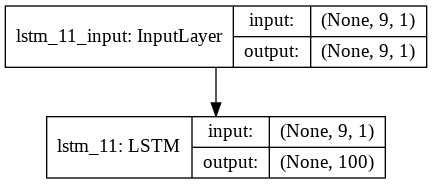

In [16]:
# connect the encoder LSTM as the output layer
model = Model(inputs=model.inputs, outputs=model.layers[0].output)
plot_model(model, show_shapes=True, to_file='lstm_encoder.png')

In [17]:
# get the feature vector for the input sequence
yhat = model.predict(sequence)
print(yhat.shape)
print(yhat)

(1, 100)
[[0.         0.         0.         0.09264076 0.         0.
  0.         0.         0.         0.         0.         0.
  0.05874647 0.01175054 0.         0.         0.         0.0265655
  0.         0.         0.         0.         0.         0.06771147
  0.11044898 0.         0.08517847 0.         0.         0.
  0.07578176 0.05290468 0.09772541 0.10388051 0.10284715 0.11354613
  0.09987298 0.         0.         0.13536848 0.         0.07932727
  0.         0.         0.         0.         0.12556441 0.
  0.05402916 0.11672521 0.07707236 0.         0.         0.
  0.02596888 0.         0.         0.06883837 0.09575706 0.
  0.10887703 0.         0.04758595 0.         0.         0.
  0.         0.         0.13783744 0.01650602 0.02202185 0.
  0.08372737 0.03457239 0.         0.09159604 0.         0.
  0.07277084 0.         0.         0.         0.         0.08184718
  0.         0.08755022 0.13818364 0.         0.         0.
  0.         0.         0.         0.         0.    

인코더 모델만을 저장해서 나중에 쓸수 있음 